# **Production Engineering**

# *BES Design*

---

![BES](Resources/BES.png)\
*Figure 1. BES System*

# **Python Libraries**

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from utilities import j, j_darcy, aof, Qb, qo_darcy, qo_vogel, qo_standing, pwf_darcy, IPR_Curve, IPR_curve_methods, gradient_avg, f_darcy

# **Design Process**

Diseñar un equipo BES en base a los datos que se muestran en el paso **1.**

## **Useful Functions**

In [2]:
# Function to show figures without axes
def figures(file):
    fig, ax = plt.subplots(figsize=(15,10))
    fig = img.imread(file)
    ax.imshow(fig)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

## 1. Data

In [3]:
# Well Data
id_casing = 7 #in
tvd_casing = 5600 #ft
tvd_liner = 6930 #ft
id_liner = 5 #in
id_tubing = 2.875 #in
TVD = 6800 #ft
pump_depth = 5500 #ft


# Production Data
p_tub = 100 #psi
p_cas = 100 #psi
q_test = 850 #bfpd
pr = 3200 #psi
pwf_test = 2600 #psi
q_d = 2300 #bpd
T_f = 160 #F
gor = 300 #scf/stb
wc = 0.75
pwh = 100 #psig

# Well fluids
sg_w = 1.085
api = 32
sg_g = 0.7
pb = 1500 #psi
z = 0.85

# Power sources
vol_pri = 12470 #V
F = 60 #Hz

## 2. Production Capacity

### 2.1. Productivity Index (J) and IPR Curve

In [5]:
# Utilizar la función para calcular J
Ip = j(q_test, pwf_test, pr, pb)
print(f"J: {Ip:.2f} bpd/psi")

J: 1.42 bpd/psi


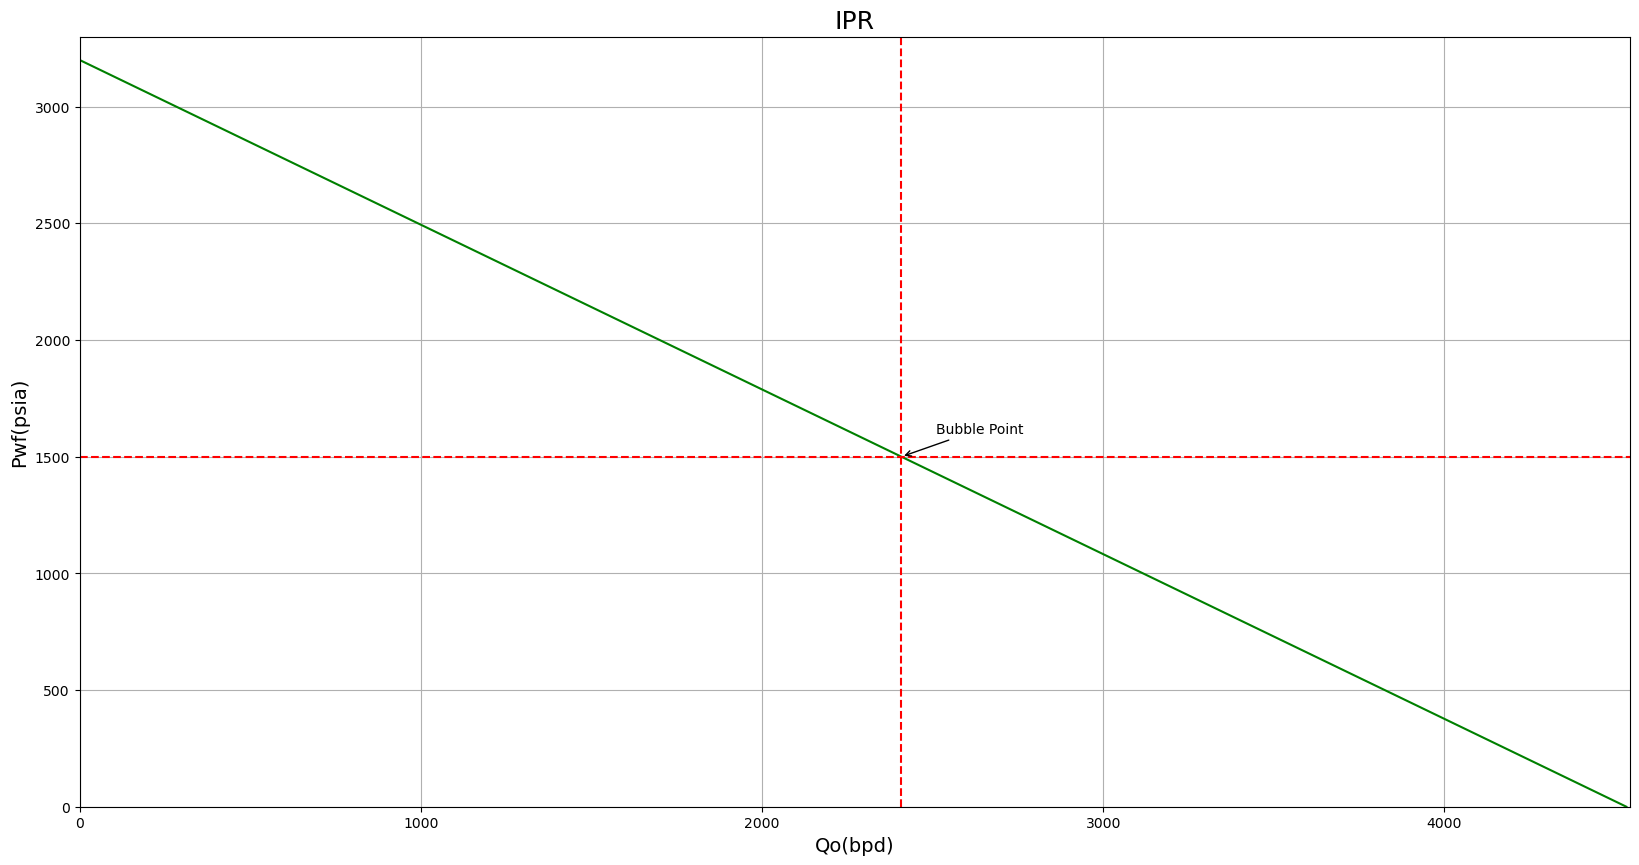

In [6]:
# IPR Curve

pwf = np.array([3200, 2500, 1800, 500, 0])
IPR_curve_methods(q_test, pwf_test, pr, pwf, pb, method="Darcy")

### 2.2. AOF Estimation

In [9]:
Qmax = aof(q_test, pwf_test, pr, pb)
print(f"AOF: {Qmax:.2f} bfpd")

AOF: 4533.33 bfpd


### 2.3. Pwf at desired production rate (Qd)

In [10]:
Pwf = pwf_darcy(q_test, pwf_test, q_d, pr, pb)
print(f"Pwf: {Pwf:.2f} psi")

Pwf: 1576.47 psi


### 2.4 Average Gradient

In [11]:
Gavg = gradient_avg(api, wc, sg_w)
print(f"Gavg: {Gavg:.2f} psi/ft")

Gavg: 0.45 psi/ft


### 2.5. PIP (P Intake)

In [13]:
pip = Pwf - ((TVD - pump_depth) * Gavg)
print(f"PIP: {pip:.2f} psi")

PIP: 996.62 psi


## 3. Gas Calculations

### 3.1. Estimate ${R_s}$ with Standing

In [14]:
def rs_std(sg, api, T, P):
    
    # Coeficiente x
    x = 0.0125 * api - 0.00091 * T
    
    Rs = sg * (((P / 18.2) + 1.4) * 10**x)**1.2048
    
    return Rs

In [20]:
rs = rs_std(sg_g, api, T_f, pip)
print(f"Rs: {rs:.2f} scf/stb")

Rs: 181.68 scf/stb


### 3.2. Estimate ${B_o}$ with Standing

In [16]:
def bo_std(sg, api, T, P, rsb, pb=None):
    
    # sgo
    sgo = 141.5 / (131.5 + api)
    
    if pb is None:
        # Pb
        pb = pb_std(sg, api, T, P, rsb)

        if P <= pb: # Yacimiento saturado
            Bo = 0.9759 + 0.000120 * (rs_std(sg, api, T, P) * (sg / sgo)**0.5 + 1.25 * T)**1.2

        else: # Yacimiento subsaturado
            # Factor volumétrico en el punto de burbuja
            Bob = 0.9759 + 0.000120 * (rs_std(sg, api, T, pb) * (sg / sgo)**0.5 + 1.25 * T)**1.2

            # Coeficiente de compresbilidad isotérmica del petróleo
            Co = co_PetFar(sg, api, T, P, rsb)

            Bo = Bob * math.e**(Co * (pb - P))
            
    else:
        pb = pb
        
        if P <= pb: # Yacimiento saturado
            Bo = 0.9759 + 0.000120 * (rs_std(sg, api, T, P) * (sg / sgo)**0.5 + 1.25 * T)**1.2

        else: # Yacimiento subsaturado
            # Factor volumétrico en el punto de burbuja
            Bob = 0.9759 + 0.000120 * (rs_std(sg, api, T, pb) * (sg / sgo)**0.5 + 1.25 * T)**1.2

            # Coeficiente de compresbilidad isotérmica del petróleo
            Co = co_PetFar(sg, api, T, P, rsb)

            Bo = Bob * math.e**(Co * (pb - P))
    
    return Bo

In [17]:
bo = bo_std(sg_g, api, T_f, pip, rs, pb)
print(f"Bo: {bo:.2f} rb/stb")

Bo: 1.12 rb/stb


### 3.3. Estimate ${B_g}$

In [18]:
# Funcion para Bg
def BG(T, P, Z):
    
    bg = (5.04 * Z * (T + 460)) / (P + 14.7)
    return bg

In [19]:
Bg = BG(T_f, pip, z)
print(f"Bg: {Bg:.2f} scf/stb")

Bg: 2.63 scf/stb


### 3.4. Total Volume of Fluids

In [30]:
# Función para calcular el volumen total de fluidos
def vol_fluids(sg, sg_w, api, T, P, rsb, wc, q, gor, Z, pb=None):
    
    # Total volume of gas
    tg = ((q * (1 - wc)) * gor) / 1000

    # Solution gas at the pump intake
    rs_pip = ((q * (1 - wc)) * rsb) / 1000
    
    # Volume of free gas FG
    fg = tg - rs_pip
    
    # Volume of oil at pump intake
    Vo = (q * (1 - wc)) * bo
    
    # Volume of free gas at the pump intake
    Vg = fg * BG(T, P, Z)
    
    # Volumen of water at the pump intake
    Vw = q * wc
    
    # Total volume of fluids
    Vt = Vo + Vg + Vw
    
    # Percentage of free gas
    per_fg = (Vg / Vt) * 100
    
    return (Vt, per_fg)

In [31]:
# Volumen total de fluidos producidos
Vt = vol_fluids(sg_g, sg_w, api, T_f, pip, rs, wc, q_d, gor, z, pb)[0]
print(f"Vt: {Vt:.2f} bfpd")

Vt: 2546.35 bfpd


In [32]:
# Percentage of free gas at the pump intake
per_gas = vol_fluids(sg_g, sg_w, api, T_f, pip, rs, wc, q_d, gor, z, pb)[1]
print(f"Per_gas: {per_gas:.2f} %")

Per_gas: 7.02 %


In [33]:
# Total mass of produced fluids at the pump intake
def tmpf(api, sg_g, sg_w, wc, q, gor):
    # api
    sg_o = 141.5 / (131.5 + api)
    
    # Volume of oil at surface
    bopd = (q * (1 - wc))
    
    # Volume of water
    bwpd = q * wc
    
    total_mass = ((bopd * sg_o + bwpd * sg_w)*62.4*5.6146) + (gor * bopd * sg_g * 0.0752)
    return total_mass

In [34]:
# Total mass of produced fluids
TMPF = tmpf(api, sg_g, sg_w, wc, q_d, gor)
print(f"TMPF: {TMPF:.2f} lbm/d")

TMPF: 839151.34 lbm/d


In [35]:
# Composite specific gravity

Sg_com = TMPF / (Vt * 5.6146 * 62.4)
print(f"Sg_com: {Sg_com:.2f}")

Sg_com: 0.94


## 4. Total Dynamic Head (TDH)

In [37]:
# Función para cálculo de TDH
def tdh(api, wc, sg_w, sg_c, P, pwh, q, id_tub, p_depth):
    
    # New average gradient
    g_avgc = sg_c * 0.433
    
    # ND
    nd = p_depth - (P / g_avgc)
    
    # Ft
    ft = (f_darcy(q, id_tub) * p_depth) / 1000
    
    # Thp
    Thp = pwh / g_avgc
    
    tdh = nd + ft + Thp
    
    return tdh            

In [38]:
# Tdh

TDH = tdh(api, wc, sg_w, Sg_com, pip, pwh, Vt, id_tubing, pump_depth)
print(f"TDH: {TDH:.2f} ft")

TDH: 3437.17 ft


## 5. Pump Type Selection

### 5.1. Load Performance Curve Selected

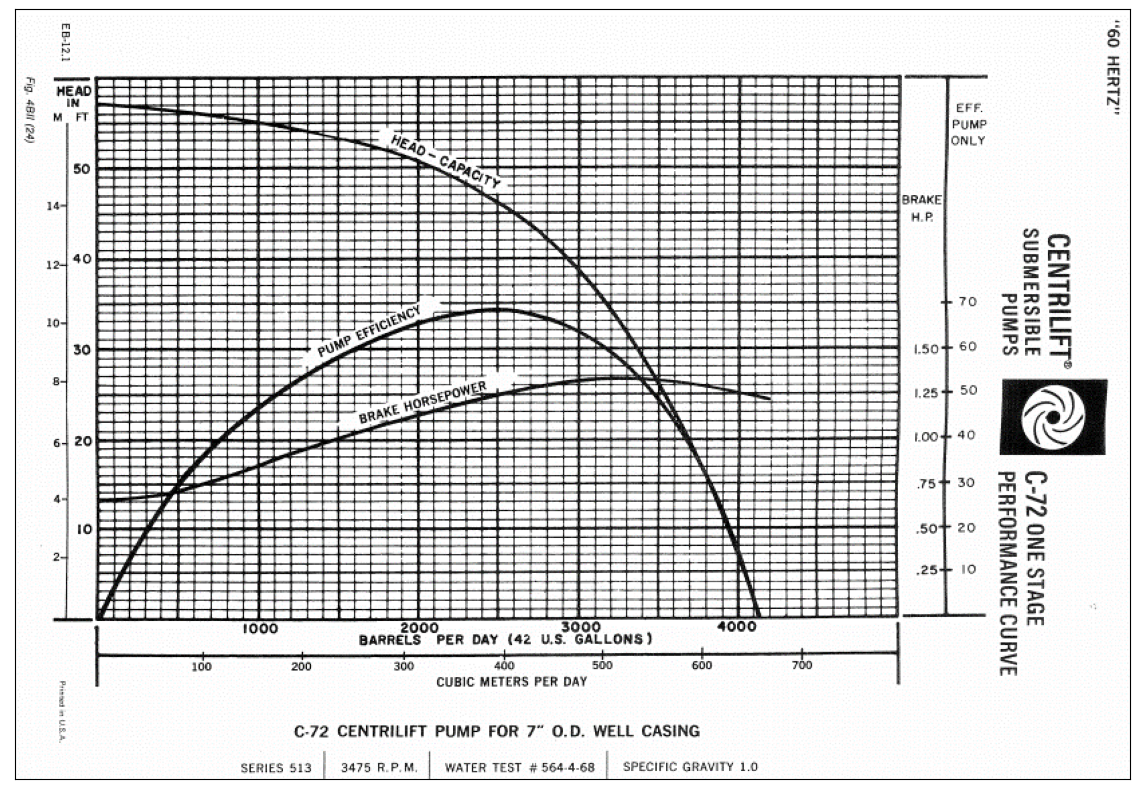

In [39]:
# Cargar curva de rendimiento elegida
file_curv = "Resources/fig5.png"

figures(file_curv)

### 5.2. Read values from Performance Curve

In [40]:
# Read tdh/stage, bhp/stage, and Eff

tdh_stg = 45.5 #ft
bhp_stg = 1.25 #hp
eff = 68 #%

In [43]:
# Stages number

nstages = TDH / tdh_stg
print(f"Nstages: {nstages:.2f} stages")

Nstages: 75.54 stages


### 5.3. Read Stages based on Pump Housing

In [44]:
# Cargar tabla de housing de la bomba
nstages = 82 # stages

In [45]:
# Potencia requerida de la bomba

bhp = bhp_stg * nstages * Sg_com
print(f"Bhp: {bhp:.2f} hp")

Bhp: 96.41 hp


## 6. Optimum Size of Components

### 6.1. Read bhp due to seal and calculate BHPt

In [48]:
# Potencia adicional debido al sello o protector
bhp_s = 2.95 #hp

In [49]:
# Potencia requerida total por la bomba
bhp_t = bhp + bhp_s
print(f"Bhp_t: {bhp_t:.2f} hp")

Bhp_t: 99.36 hp


### 6.2. Motor Selection

In [50]:
bhp_m = 125 #hp
V_m = 2270 #V
I_m = 35 #Amp

# 7. Electric Cable

# 8. Accesory and Miscellaneous Equipment